![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> LEcture 23 - Outliers Detection </center>
### <center> Isolation Forest</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/23_OutlierDetection/MainIsolationForest.ipynb)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### Load the credit card data:
* https://www.kaggle.com/mlg-ulb/creditcardfraud
* The data is after PCA (to mask the real featrues)

In [3]:
dData = pd.read_csv('../../data/creditcard.csv')
dData

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


#### Note that the data is extremely unbalanced:

In [4]:
dData['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
dData['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

#### You can consider  the `Time` feature as well:
(For this notebook we will not use it)

In [6]:
mX = dData.drop(columns=['Time', 'Class']).values
vY = dData['Class'].values
mX.shape, vY.shape

((284807, 29), (284807,))

### Train:
* Random Forest
* Isolation Forest

In [7]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.ensemble  import IsolationForest

In [8]:
%%time
oRndForest = RandomForestClassifier(n_estimators=50, oob_score=True).fit(mX, vY)

Wall time: 1min 58s


In [9]:
%%time
oIsoForest = IsolationForest().fit(mX)

Wall time: 5.33 s


### ROC:

In [10]:
from sklearn.metrics import roc_curve, auc

vScoreRF =  oRndForest.oob_decision_function_[:,1]
vScoreIF = -oIsoForest.decision_function(mX)

In [11]:
vFP_RF, vTP_RF, vThersholdRF = roc_curve(vY, vScoreRF, pos_label=1)
vFP_IF, vTP_IF, vThersholdIF = roc_curve(vY, vScoreIF, pos_label=1)

AUC_RF = auc(vFP_RF, vTP_RF)
AUC_IF = auc(vFP_IF, vTP_IF)

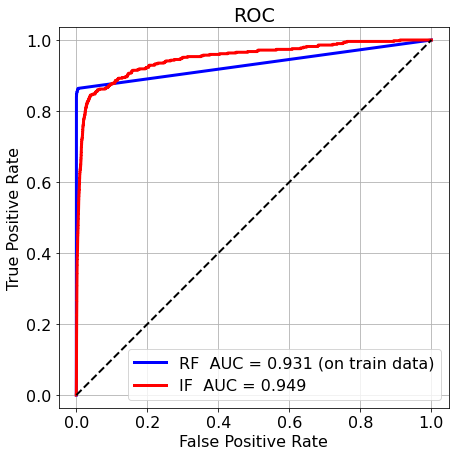

In [12]:
plt.figure(figsize=(7, 7))
plt.plot  (vFP_RF, vTP_RF, color='b', lw=3, label=f'RF  AUC = {AUC_RF :.3f} (on train data)')
plt.plot  (vFP_IF, vTP_IF, color='r', lw=3, label=f'IF  AUC = {AUC_IF :.3f}')
plt.plot  ([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.title ('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis  ('equal')
plt.legend()
plt.grid  ()
plt.show  ()

In [13]:
#-- This is only to improve the visualization of the following cell:
vScoreRF2                    = vScoreRF + np.random.randn(len(vY)) / 100000
vFP_RF, vTP_RF, vThersholdRF = roc_curve(vY, vScoreRF2, pos_label=1)

### Plot ROC and confusion matrices:

In [15]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from ipywidgets      import interact, IntSlider, Layout

v              = np.linspace(0, 1, 101, endpoint=True)
vThersholdRF2  = np.interp(v, vFP_RF,  vThersholdRF)
vThersholdIF2  = np.interp(v, vFP_IF,  vThersholdIF)

def PlotConfusionMatrices(thr):
    
    thrRF    = vThersholdRF2[thr]
    thrIF    = vThersholdIF2[thr]
    vHatY_RF = vScoreRF2 > thrRF
    vHatY_IF = vScoreIF  > thrIF
        
    mC_RF = confusion_matrix(vY, vHatY_RF)
    mC_IF = confusion_matrix(vY, vHatY_IF)
    
    fig = plt.figure(figsize=(16, 10))
    ax  = fig.add_subplot(1, 2, 1)
    ax.plot      (vFP_RF, vTP_RF, color='b', lw=3, label=f'RF AUC = {AUC_RF :.3f} (on train data)')
    ax.plot      (vFP_IF, vTP_IF, color='r', lw=3, label=f'IF AUC = {AUC_IF :.3f}')
    ax.plot      ([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    ax.axvline   (x=thr/100.0, color='g', lw=2, linestyle='--')
    ax.set_title ('ROC')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.axis      ('equal')
    ax.legend    ()
    ax.grid      ()    
    
    axRF = fig.add_subplot(2, 3, 3)
    axIF = fig.add_subplot(2, 3, 6)
    
    ConfusionMatrixDisplay(mC_RF, display_labels=['Normal', 'Fruad']).plot(ax=axRF)
    ConfusionMatrixDisplay(mC_IF, display_labels=['Normal', 'Fruad']).plot(ax=axIF)
    axRF.set_title('Random Forest   \n' f'f1_score = {f1_score(vY, vHatY_RF):1.4f}')
    axIF.set_title('Isolation Forest\n' f'f1_score = {f1_score(vY, vHatY_IF):1.4f}')
#     plt.tight_layout()
    plt.show        ()
    
thrSlider = IntSlider(min=0, max=100, step=1, value=0, layout=Layout(width='80%'))
interact(PlotConfusionMatrices, thr=thrSlider);

interactive(children=(IntSlider(value=0, description='thr', layout=Layout(width='80%')), Output()), _dom_class…